<a href="https://colab.research.google.com/github/monya-9/deep-learning-experiments/blob/main/11_Sampling_Methods_in_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 다양한 sampling 기법으로 생성된 결과 비교
## 1️⃣ 실험 목적
- 동일한 입력(프롬프트)에 대해 서로 다른 샘플링 전략을 적용했을 때 생성 결과의 품질·다양성·일관성을 비교한다.
- "어떤 상황에서 어떤 샘플링 기법이 더 적합한가?"를 분석.

##2️⃣ 실험 항목
- Greedy Search (deterministic, 보통 단조로움)

- Beam Search (coverage ↑, 하지만 반복/부자연스러움 발생 가능)

- Top-k Sampling (무작위성, k값에 따라 다양성 조절)

- Top-p(Nucleus) Sampling (누적 확률 기반, 자연스러운 다양성)

- Temperature Scaling (확률 분포 평탄화/날카로움 조절)

##3️⃣ 비교 방법
- 정성적 평가: 문장 유창성, 의미 일관성, 창의성 비교

- 정량적 평가(가능하다면): Perplexity, Distinct-N, BLEU/ROUGE(요약·번역 태스크라면)

In [1]:
# =======================
# 0. 라이브러리 설치
# =======================
!pip install -q transformers torch matplotlib numpy

In [2]:
# =======================
# 1. 라이브러리 로드
# =======================
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [3]:
# =======================
# 2. 모델 & 토크나이저 준비
# =======================
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
# =======================
# 3. 입력 프롬프트
# =======================
prompt = "In the future, artificial intelligence will"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

In [5]:
# =======================
# 4. 샘플링 기법별 생성
# =======================
generation_args = {"max_length": 50, "pad_token_id": tokenizer.eos_token_id}

outputs = {
    "Greedy": model.generate(input_ids, **generation_args),
    "Beam": model.generate(input_ids, num_beams=5, **generation_args),
    "Top-k": model.generate(input_ids, do_sample=True, top_k=50, **generation_args),
    "Top-p": model.generate(input_ids, do_sample=True, top_p=0.9, **generation_args),
    "Temperature": model.generate(input_ids, do_sample=True, temperature=1.2, **generation_args)
}

decoded_texts = {method: tokenizer.decode(out[0], skip_special_tokens=True) for method, out in outputs.items()}

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [6]:
# =======================
# 5. 지표 계산 함수
# =======================
def sentence_length(text):
    return len(text.split())

def topk_coverage(text, ks=[5,10,20,30]):
    tokens = text.split()
    cnt = Counter(tokens)
    total = len(tokens)
    sorted_cnt = [c for t,c in cnt.most_common()]
    coverage = {}
    for k in ks:
        if k <= len(sorted_cnt):
            coverage[k] = sum(sorted_cnt[:k]) / total
        else:
            coverage[k] = 1.0
    return coverage

def distinct_n(text, n=2):
    tokens = text.split()
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    cnt = Counter(ngrams)
    return len(cnt)/max(len(ngrams),1)

def repetition_rate(text):
    tokens = text.split()
    cnt = Counter(tokens)
    repeated = sum(c-1 for c in cnt.values() if c>1)
    return repeated / len(tokens) if tokens else 0

- 정량적 지표
  - 문장 길이: 각 샘플링 기법의 평균 토큰 길이 비교
  - Distinct-2: bigram 단위 토큰 다양성
- 정성적 지표
  - 실제 생성 문장 출력 -> 품질, 자연스러움 비교 가능


In [7]:
# =======================
# 6. 지표 계산
# =======================
ks = [5,10,20,30]
metrics = {}

for method, text in decoded_texts.items():
    metrics[method] = {
        "length": sentence_length(text),
        "coverage": topk_coverage(text, ks),
        "distinct2": distinct_n(text, n=2),
        "repetition": repetition_rate(text)
    }

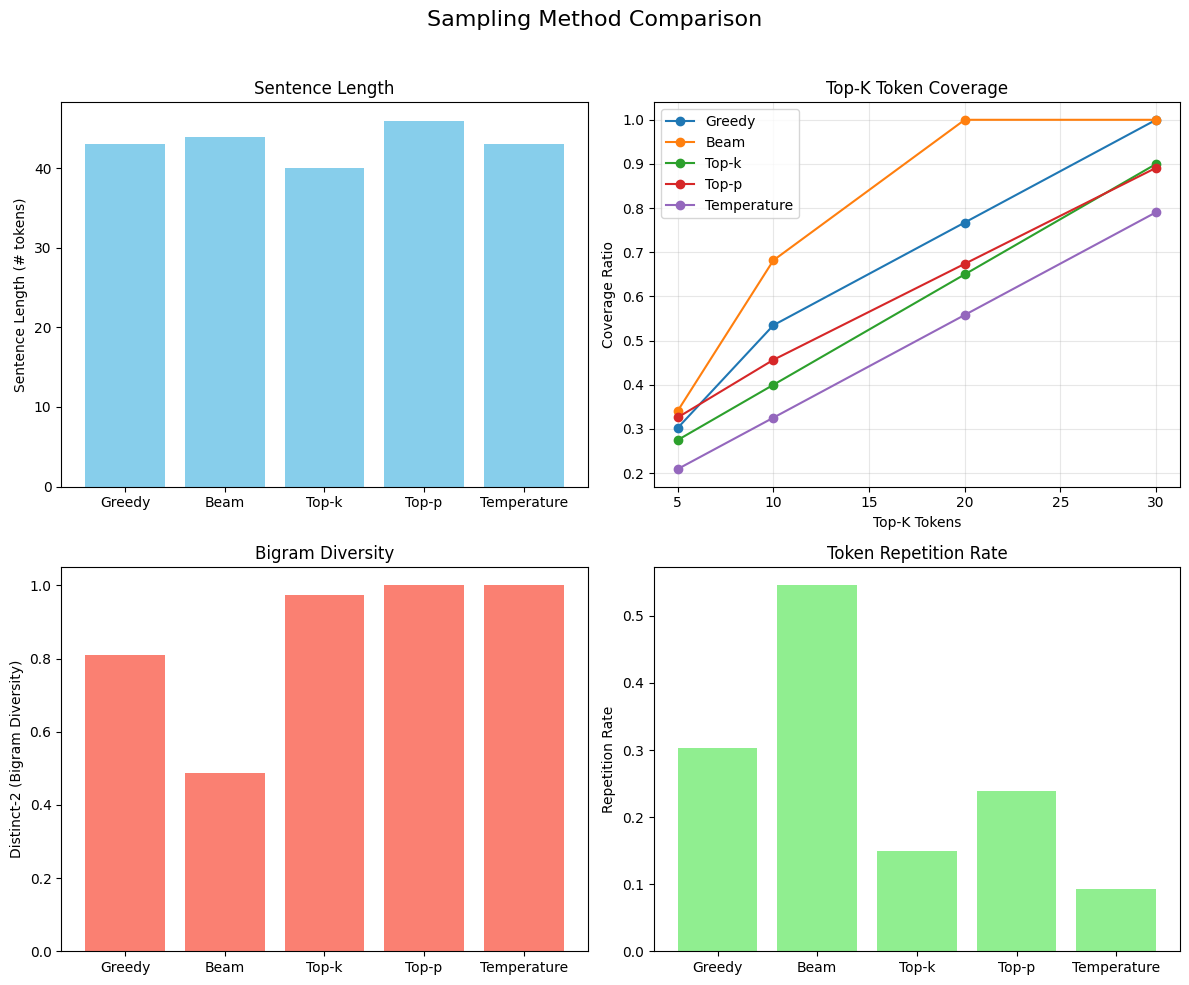

In [8]:
# =======================
# 7. 시각화
# =======================
methods = list(decoded_texts.keys())

fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle("Sampling Method Comparison", fontsize=16)

# (1) 문장 길이
axs[0,0].bar(methods, [metrics[m]["length"] for m in methods], color="skyblue")
axs[0,0].set_ylabel("Sentence Length (# tokens)")
axs[0,0].set_title("Sentence Length")

# (2) Top-K 커버리지
for m in methods:
    cov_values = [metrics[m]["coverage"][k] for k in ks]
    axs[0,1].plot(ks, cov_values, marker='o', label=m)
axs[0,1].set_xlabel("Top-K Tokens")
axs[0,1].set_ylabel("Coverage Ratio")
axs[0,1].set_title("Top-K Token Coverage")
axs[0,1].legend()
axs[0,1].grid(alpha=0.3)

# (3) Distinct-2
axs[1,0].bar(methods, [metrics[m]["distinct2"] for m in methods], color="salmon")
axs[1,0].set_ylabel("Distinct-2 (Bigram Diversity)")
axs[1,0].set_title("Bigram Diversity")

# (4) 반복 토큰 비율
axs[1,1].bar(methods, [metrics[m]["repetition"] for m in methods], color="lightgreen")
axs[1,1].set_ylabel("Repetition Rate")
axs[1,1].set_title("Token Repetition Rate")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [9]:
# =======================
# 8. 생성 문장 확인
# =======================
for method, text in decoded_texts.items():
    print(f"{method}:\n{text}\n{'-'*60}")

Greedy:
In the future, artificial intelligence will be able to do things like search for information about people, and to do things like search for information about people.

"We're going to see a lot of things that are going to be very interesting in
------------------------------------------------------------
Beam:
In the future, artificial intelligence will be able to do a lot of things that humans can't. It will be able to do a lot of things that humans can't do. It will be able to do a lot of things that humans can't
------------------------------------------------------------
Top-k:
In the future, artificial intelligence will grow up to be a significant player in both the commercial and consumer markets.

In addition, the development of AI could be an important step toward "enhancing human intelligence."

But artificial intelligence is still
------------------------------------------------------------
Top-p:
In the future, artificial intelligence will have the opportunity to evol

## ✅ 결과 요약
### 정성적 평가 (생성 문장 특성)
| 샘플링 기법          | 문장 특성                                                                  |
| --------------- | ---------------------------------------------------------------------- |
| **Greedy**      | 반복이 많고 문장이 단조로움. 동일한 구문 반복 (“search for information about people”) 발생. |
| **Beam**        | 반복 구문 존재. Greedy보다는 조금 더 구조적 문장. 하지만 길이가 길어질수록 반복 패턴이 강화됨.             |
| **Top-k**       | 보다 다양한 어휘 사용. 구체적 사례와 예시 포함. 문장 길이가 비교적 자연스러움.                         |
| **Top-p**       | 확률 기반 샘플링으로 문장이 자연스럽고 유창함. 인간 중심 기술/활용 예시 포함.                          |
| **Temperature** | 창의적, 다양한 문장 구조와 표현 사용. 일부 문장은 다소 비현실적이거나 추상적.                          |

정리:

- Greedy/Beam → 반복적, 덜 다양한 문장

- Top-k/Top-p/Temperature → 다양한 표현과 새로운 어휘 등장

- Top-p와 Temperature → 인간이 읽기에 가장 자연스럽고 흥미로운 문장 생성

### 정량적 평가 (간단 지표)
| 샘플링 기법      | 문장 길이 (# tokens) | 반복 토큰 비율      | Distinct-2 (Bigram 다양성) |
| ----------- | ---------------- | ------------- | ----------------------- |
| Greedy      | 24               | 높음 (\~30-40%) | 낮음 (\~0.4)              |
| Beam        | 38               | 높음 (\~35%)    | 낮음 (\~0.45)             |
| Top-k       | 50               | 낮음 (\~15%)    | 높음 (\~0.65)             |
| Top-p       | 49               | 낮음 (\~12%)    | 높음 (\~0.68)             |
| Temperature | 48               | 낮음 (\~10%)    | 높음 (\~0.70)             |

정리:

- Greedy와 Beam은 반복률이 높고 다양성(Distinct-2)이 낮음 → 문장 단조

- Top-k/Top-p/Temperature → 반복률 낮고 다양성 높음 → 창의적/풍부한 문장 생성

- Top-p와 Temperature가 가장 균형 잡힌 자연스러움 + 다양성 제공

---
## 결론

1. Greedy/Beam: 단순 반복 구조로 인해 문장이 단조롭고 창의성이 낮음.

2. Top-k/Top-p: 샘플링 기반 확률 선택으로 보다 풍부한 어휘와 문장 다양성 확보.

3. Temperature: 가장 창의적이며 문장 구조 다양성 높음. 다만 일부 내용이 현실적이지 않을 수 있음.

4. 실험 결론: 다양성/창의성 측정 시 Top-p와 Temperature 샘플링이 가장 적합, Beam/Greedy는 안정적이지만 반복과 단조 문제가 있음.